In [6]:
# # The slab detachment benchmark
#
# Slab detachment benchark, as outlined  [Schmalholz, 2011](https://www.sciencedirect.com/science/article/pii/S0012821X11000252?casa_token=QzaaLiBMuiEAAAAA:wnpjH88ua6bj73EAjkoqmtiY5NWi9SmH7GSjvwvY_LNJi4CLk6vptoN93xM1kyAwdWa2rnbxa-U) and [Glerum et al., 2018](https://se.copernicus.org/articles/9/267/2018/se-9-267-2018.pdf)
# - [ASPECT benchmark](https://aspect-documentation.readthedocs.io/en/latest/user/benchmarks/benchmarks/slab_detachment/doc/slab_detachment.html)
# from Ben


resx: 50
resy: 33
proc: 1



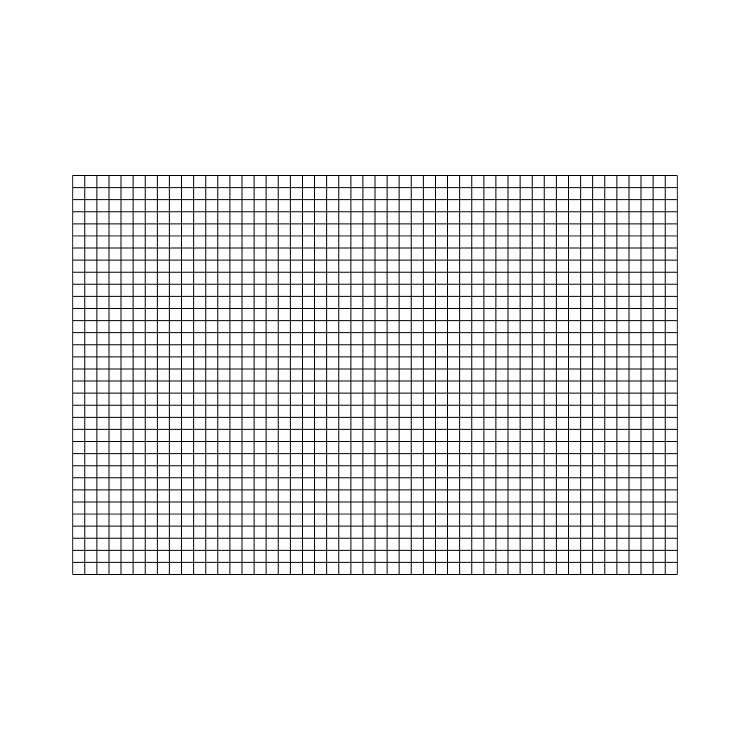

In [2]:
from petsc4py import PETSc
import underworld3 as uw
import numpy as np
import sympy
import petsc4py
import pyvista as pv

import glob
import os

# %%
options = PETSc.Options()


options["snes_converged_reason"] = None
options["snes_monitor_short"] = None

sys = PETSc.Sys()
sys.pushErrorHandler("traceback")

# %%
### plot figs
if uw.mpi.size == 1:
    render = True
else:
    render = False
    
    
### linear or nonlinear version
linear = False ### False for NL version


# %%
## number of steps
nsteps = 10

## swarm gauss point count (particle distribution)
swarmGPC = 2


### distance between elements, in km
res = 20

### Recycle rate of particles
recycle_rate = 0

# %%
outputPath = f'./output/slabDetachment_res={res}km_recycleRate={recycle_rate}/'

# %%
reload = False

if uw.mpi.rank == 0:
    # checking if the directory
    # exist or not.
    if os.path.exists(outputPath):
        reload = True
        restart_step = os.path.basename(max(glob.iglob(outputPath + 'swarm*xmf'), key=os.path.getctime))[-9:-4]
        pv_mesh_data = pv.XdmfReader(outputPath + f'step_{restart_step}.xdmf').read()
        time_d =  pv_mesh_data['time_time'][0]
    
    else:

        # if the demo_folder directory is not present 
        # then create it.
        os.makedirs(outputPath)

        step = 0
        time = 0.
        restart_step = -1



# %% [markdown]
# #### Set up scaling of model

# %%
# import unit registry to make it easy to convert between units
u = uw.scaling.units

### make scaling easier
ndim = uw.scaling.non_dimensionalise
nd   = uw.scaling.non_dimensionalise
dim  = uw.scaling.dimensionalise 

# %%
### set reference values
velocity     = 1e-11 * u.meter / u.second
model_height = 660.  * u.kilometer
bodyforce    = 3300  * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
mu           = 1e22  * u.pascal * u.second

KL = model_height
Kt = KL / velocity
# KM = bodyforce * KL**2 * Kt**2
KM = mu * KL * Kt


scaling_coefficients  = uw.scaling.get_coefficients()

scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt
scaling_coefficients["[mass]"]= KM

scaling_coefficients

# %%
ND_gravity = nd( 9.81 * u.meter / u.second**2 )

# %%
ND_gravity * nd(3.3e3*u.kilogram/u.meter**3)

# %%
### add material index
BGIndex = 0
SlabIndex = 1

# %% [markdown]
# Set up dimensions of model and sinking block

# %%
xmin, xmax = 0., ndim(1000*u.kilometer)
ymin, ymax = 0., ndim(660*u.kilometer)



# %%
resx = int(1000 / res)
resy = int(660 / res)

# %%
if uw.mpi.rank == 0:
    print(f'')
    print(f'resx: {resx}')
    print(f'resy: {resy}')
    print(f'proc: {uw.mpi.size}')
    print(f'')

# %% [markdown]
# ### Create mesh

# %%
# mesh = uw.meshing.UnstructuredSimplexBox(minCoords=(xmin, ymin), maxCoords=(xmax, ymax), cellSize=1.0 / resy, regular=False)


mesh = uw.meshing.StructuredQuadBox(elementRes =(int(resx),int(resy)),
                                    minCoords=(xmin,ymin), 
                                    maxCoords=(xmax,ymax))

# check the mesh if in a notebook / serial

if uw.mpi.size == 1:

    import numpy as np
    import pyvista as pv
    import vtk

    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 750]
    #pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True

    # pv.start_xvfb()

    mesh.vtk(outputPath + "SD_mesh.vtk")
    pvmesh = pv.read(outputPath + "SD_mesh.vtk")

    # with mesh1.access():
        # usol = stokes.u.data.copy()


    pl = pv.Plotter(window_size=(750, 750))

    pl.add_mesh(pvmesh,'Black', 'wireframe')


    pl.show(cpos="xy")

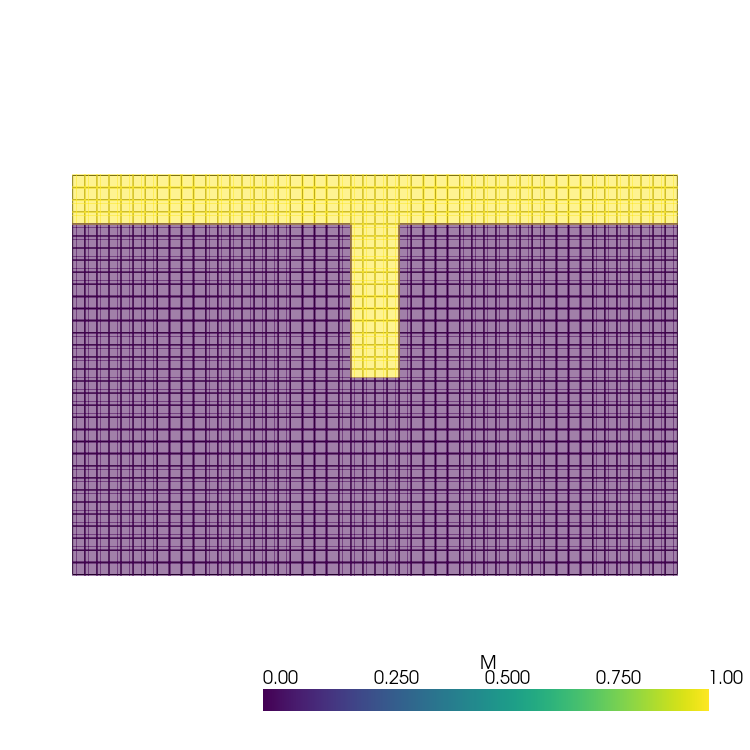

In [3]:
# %% [markdown]
# ### Create Stokes object

# %%
v = uw.discretisation.MeshVariable('U',    mesh,  mesh.dim, degree=2 )
# p = uw.discretisation.MeshVariable('P',    mesh, 1, degree=1 )
p = uw.discretisation.MeshVariable('P',    mesh, 1, degree=1,  continuous=True)

### Create mesh variables to project stuff onto
strain_rate_inv2 = uw.discretisation.MeshVariable("SR", mesh, 1, degree=2)
dev_stress_inv2 = uw.discretisation.MeshVariable("stress", mesh, 1, degree=1)
node_viscosity = uw.discretisation.MeshVariable("viscosity", mesh, 1, degree=1)

timeField      = uw.discretisation.MeshVariable("time", mesh, 1, degree=1)
materialField  = uw.discretisation.MeshVariable("material", mesh, 1, degree=1)


# %%
stokes = uw.systems.Stokes(mesh, velocityField=v, pressureField=p )

stokes.constitutive_model = uw.constitutive_models.ViscousFlowModel

# %% [markdown]
# #### Setup swarm

# %%
swarm     = uw.swarm.Swarm(mesh=mesh, recycle_rate=recycle_rate)

### Material index swarm with 2 indicies (crust and mantle)
material  = uw.swarm.IndexSwarmVariable("M", swarm, indices=2)



# %%
if reload == False: 
    swarm.populate_petsc(swarmGPC)
    for i in [material]:
            with swarm.access(i):
                i.data[:] = BGIndex
                i.data[(swarm.data[:,1] >= ndim((660-80) * u.kilometer))] = SlabIndex
    
                i.data[(swarm.data[:,1] >= ndim((660-(250+80)) * u.kilometer)) & 
                       (swarm.data[:,0] >= ndim((500-40)*u.kilometer)) &
                       (swarm.data[:,0] <= ndim((500+40)*u.kilometer))] = SlabIndex

else:
    pv_swarm_data = pv.XdmfReader(outputPath + f'swarm_{restart_step}.xmf').read()

    swarm.add_particles_with_coordinates(np.ascontiguousarray( pv_swarm_data.points[:,0:2] ))

    with swarm.access(material):
        material.data[:,0] = pv_swarm_data['material']

    time = nd(time_d*u.megayear)
    step = int(restart_step)
    


# %%
# check the mesh if in a notebook / serial
if uw.mpi.size == 1:

    import numpy as np
    import pyvista as pv
    import vtk

    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 750]
    #pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True

    # pv.start_xvfb()

    pvmesh = pv.read(outputPath + "SD_mesh.vtk")

    # with mesh1.access():
        # usol = stokes.u.data.copy()


    pl = pv.Plotter(window_size=(750, 750))

    pl.add_mesh(pvmesh,'Black', 'wireframe')

    # pl.add_mesh(
    #     pvmesh, cmap="coolwarm", edge_color="Black", show_edges=True, scalars="T", use_transparency=False, opacity=0.5
    # )

    with swarm.access('M'):
        points = np.zeros((swarm.particle_coordinates.data.shape[0], 3))
        points[:, 0] = swarm.particle_coordinates.data[:, 0]
        points[:, 1] = swarm.particle_coordinates.data[:, 1]
        
        point_cloud = pv.PolyData(points)
        
        point_cloud.point_data["M"] = material.data.copy()
        
    pl.add_points(point_cloud, render_points_as_spheres=False, point_size=5, opacity=0.5)
    
    # pl.add_arrows(arrow_loc2, arrow_length2, mag=1.0e-1)

    # pl.add_points(pdata)

    pl.show(cpos="xy")

# %% [markdown]
# ##### Additional mesh vars to save

# %%
nodal_strain_rate_inv2 = uw.systems.Projection(mesh, strain_rate_inv2)
nodal_strain_rate_inv2.uw_function = stokes.Unknowns.Einv2
nodal_strain_rate_inv2.smoothing = 0.
nodal_strain_rate_inv2.petsc_options.delValue("ksp_monitor")

nodal_visc_calc = uw.systems.Projection(mesh, node_viscosity)
nodal_visc_calc.uw_function = stokes.constitutive_model.Parameters.shear_viscosity_0
nodal_visc_calc.smoothing = 0.
nodal_visc_calc.petsc_options.delValue("ksp_monitor")


nodal_tau_inv2 = uw.systems.Projection(mesh, dev_stress_inv2)
nodal_tau_inv2.uw_function = 2. * stokes.constitutive_model.Parameters.shear_viscosity_0 * stokes.Unknowns.Einv2
nodal_tau_inv2.smoothing = 0.
nodal_tau_inv2.petsc_options.delValue("ksp_monitor")

# matProj = uw.systems.Projection(mesh, materialField)
# matProj.uw_function = materialVariable.sym[0]
# matProj.smoothing = 0.
# matProj.petsc_options.delValue("ksp_monitor")


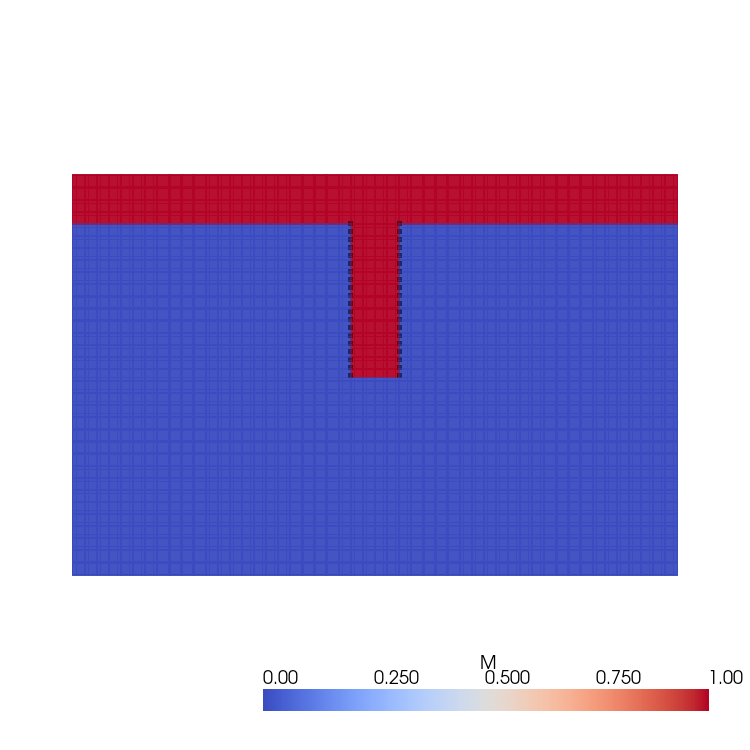

  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solve converged due to CONVERGED_FNORM_ABS iterations 5


In [4]:
### create function to update fields
def updateFields(time):
    
    with mesh.access(timeField):
        timeField.data[:,0] = dim(time, u.megayear).m

    nodal_strain_rate_inv2.solve()

    
    # matProj.uw_function = materialVariable.sym[0] 
    # matProj.solve(_force_setup=True)


    nodal_visc_calc.uw_function = stokes.constitutive_model.Parameters.shear_viscosity_0
    nodal_visc_calc.solve(_force_setup=True)

    nodal_tau_inv2.uw_function = 2. * stokes.constitutive_model.Parameters.shear_viscosity_0 * stokes.Unknowns.Einv2
    nodal_tau_inv2.solve(_force_setup=True)


# %% [markdown]
# ##### Create fig function to visualise mat

# %%
def plot_mat():

    import numpy as np
    import pyvista as pv
    import vtk

    pv.global_theme.background = 'white'
    pv.global_theme.window_size = [750, 750]
    #pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.smooth_shading = True


    pvmesh = pv.read(outputPath + "SD_mesh.vtk")

    with swarm.access():
        points = np.zeros((swarm.data.shape[0],3))
        points[:,0] = swarm.data[:,0]
        points[:,1] = swarm.data[:,1]
        points[:,2] = 0.0

    point_cloud = pv.PolyData(points)
    
    ### create point cloud for passive tracers
    with passiveSwarm_L.access():
        passiveCloud_L = pv.PolyData(np.vstack((passiveSwarm_L.data[:,0],passiveSwarm_L.data[:,1], np.zeros(len(passiveSwarm_L.data)))).T)
        
    with passiveSwarm_R.access():
        passiveCloud_R = pv.PolyData(np.vstack((passiveSwarm_R.data[:,0],passiveSwarm_R.data[:,1], np.zeros(len(passiveSwarm_R.data)))).T)


    with swarm.access():
        point_cloud.point_data["M"] = material.data.copy()
        



    pl = pv.Plotter(notebook=True)

    pl.add_mesh(pvmesh,'Black', 'wireframe')

    # pl.add_points(point_cloud, color="Black",
    #                   render_points_as_spheres=False,
    #                   point_size=2.5, opacity=0.75)       



    pl.add_mesh(point_cloud, cmap="coolwarm", edge_color="Black", show_edges=False, scalars="M",
                        use_transparency=False, opacity=0.95)
    
    ### add points of passive tracers
    pl.add_mesh(passiveCloud_L, color='black', show_edges=True,
                    use_transparency=False, opacity=0.95)
    
    pl.add_mesh(passiveCloud_R, color='black', show_edges=True,
                    use_transparency=False, opacity=0.95)



    pl.show(cpos="xy")


# %% [markdown]
# #### Boundary conditions

# %%
sol_vel = sympy.Matrix([0., 0.])

# No slip left & right & free slip top & bottom
stokes.add_dirichlet_bc( sol_vel, "Left" ) 
stokes.add_dirichlet_bc( sol_vel, "Right")
stokes.add_dirichlet_bc( [None,0.], "Top")  
stokes.add_dirichlet_bc( [None,0.], "Bottom")




# %% [markdown]
# ### Add a passive tracer(s)

# %%
passiveSwarm_L = uw.swarm.Swarm(mesh)

passiveSwarm_R = uw.swarm.Swarm(mesh)

if reload == False:
    y = np.linspace(nd((660-80)*u.kilometer), nd((660-330)*u.kilometer), 20)
    
    x0 = np.zeros_like(y) + nd((500-40)*u.kilometer)
    
    x1 = np.zeros_like(y) + nd((500+40)*u.kilometer)
    tracers_L = np.vstack([x0,y]).T
    tracers_R = np.vstack([x1,y]).T

    passiveSwarm_L.add_particles_with_coordinates(np.ascontiguousarray(tracers_L))


    passiveSwarm_R.add_particles_with_coordinates(np.ascontiguousarray(tracers_R))

else:
    pv_swarm_L = pv.XdmfReader(outputPath + f'PT_L_{restart_step}.xmf').read()

    passiveSwarm_L.add_particles_with_coordinates(np.ascontiguousarray( pv_swarm_L.points[:,0:2] ))

    pv_swarm_R = pv.XdmfReader(outputPath + f'PT_R_{restart_step}.xmf').read()

    passiveSwarm_R.add_particles_with_coordinates(np.ascontiguousarray( pv_swarm_R.points[:,0:2] ))



# %% [markdown]
# #### Visualise swarm and passive tracers

# %%
if render == True & uw.mpi.size==1:
    plot_mat()

# %% [markdown]
# #### Set up density and viscosity of materials

# %%
### set density of materials
densityBG     = nd(3150* u.kilogram / u.metre**3)
densitySlab   = nd(3300* u.kilogram / u.metre**3)

# %%
density_fn = material.createMask([densityBG, densitySlab])

# %%
stokes.bodyforce = sympy.Matrix([0, -1 * ND_gravity * density_fn])

stokes.bodyforce

# %% [markdown]
# ### set some petsc options

# %%
# Set solve options here (or remove default values
# stokes.petsc_options["ksp_monitor"] = None

if uw.mpi.size == 1:
    stokes.petsc_options['pc_type'] = 'lu'

stokes.tolerance = 1.0e-5

### see the SNES output
stokes.petsc_options["snes_converged_reason"] = None

# %% [markdown]
# ### Initial linear solve

# %%
### linear solve

viscosity_L_fn = material.createMask([nd(1e21*u.pascal*u.second),
                                      nd(1e24*u.pascal*u.second)])




stokes.constitutive_model.Parameters.shear_viscosity_0 = viscosity_L_fn
stokes.saddle_preconditioner = 1.0 / viscosity_L_fn


# %%
stokes.solve(zero_init_guess=False)

# %% [markdown]
# #### Introduce NL viscosity
#
# ##### Viscosity is limited betweeen 10$^{21}$ and 10$^{25}$ Pa S
#
#
# - $\eta_s = \eta_0 \, \dot\varepsilon^{1/n-1} $
# - n = 4
# - $\eta_0=4.75\times 10^{11}\text{ Pa s} $

# %%
### Set constants for the viscosity and density of the sinker.
viscBG        = nd(1e21*u.pascal*u.second)


if linear == False: 
    n = 4
    Slab_visc      = nd(4.75e11*u.pascal*u.second**(1/n))

    viscSlab = sympy.Max(sympy.Min(Slab_visc * sympy.Pow(stokes.Unknowns.Einv2, (1/n-1)), nd(1e25*u.pascal*u.second)), nd(1e21*u.pascal*u.second))


else:
    n = 1
    Slab_visc      = nd(2e23*u.pascal*u.second)
    viscSlab       = sympy.Max(sympy.Min(Slab_visc, nd(1e25*u.pascal*u.second)), nd(1e21*u.pascal*u.second))


viscosity_mat_fn = material.createMask([viscBG,
                                       viscSlab])
    


# %%
stokes.constitutive_model.Parameters.shear_viscosity_0 

# %%
# ### add in material-based viscosity

stokes.constitutive_model.Parameters.shear_viscosity_0 = viscosity_mat_fn
stokes.saddle_preconditioner = 1.0 / viscosity_mat_fn



# %% [markdown]
# #### Save mesh to h5/xdmf file
# Function to put in solver loop

# %%
def saveData(step, outputPath, time):

    ### add mesh vars to viewer to save as one h5/xdmf file. Has to be a PETSc object (?)
    mesh.petsc_save_checkpoint(index=step, 
                               meshVars=[v, p, strain_rate_inv2,node_viscosity, timeField], 
                                outputPath=outputPath)
    
    
    #### save the swarm and selected variables
    swarm.petsc_save_checkpoint('swarm', step, outputPath)
    
    passiveSwarm_L.petsc_save_checkpoint('PT_L', step, outputPath)
    passiveSwarm_R.petsc_save_checkpoint('PT_R', step, outputPath)
    


# %%
time_array = np.zeros(nsteps)*np.nan
NeckWidth  = np.zeros(nsteps)*np.nan

# %%
if reload == True:
    time_load = np.load(outputPath + f'modelTime-{res}km.npz')['arr_0']
    time_array[:time_load.shape[0]] = nd(time_load* u.megayear)

    width_load = np.load(outputPath + f'NeckWidth-{res}km.npz')['arr_0']
    NeckWidth[:time_load.shape[0]] = nd(width_load*u.kilometer)

    if uw.mpi.rank==0:
        print('starting from:')
        print(f"\n\nStep: {str(step).rjust(3)}, time: {dim(time, u.megayear).m:6.2f} Myr, Necking width:  {dim(NeckWidth[step], u.kilometer).m:6.2f} km \n\n")




# %% [markdown]
# ### Solver loop for multiple iterations

# %%



Save data: 


  Nonlinear  solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  Nonlinear  solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  Nonlinear  solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


Step:   0, time:   0.00 Myr, Necking width:   80.00 km 


  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solve did not converge due to DIVERGED_LINE_SEARCH iterations 9


Step:   1, time:   5.95 Myr, Necking width:   74.84 km 


  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solve converged due to CONVERGED_FNORM_ABS iterations 40


Step:   2, time:   9.22 Myr, Necking width:   69.29 km 


  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solve converged due to CONVERGED_FNORM_ABS iterations 12


Step:   3, time:  12.04 Myr, Necking width:   64.59 km 


  Nonlinear  solve did not converge due to DIVERGED_MAX_IT iterations 0
  Nonlinear  solv

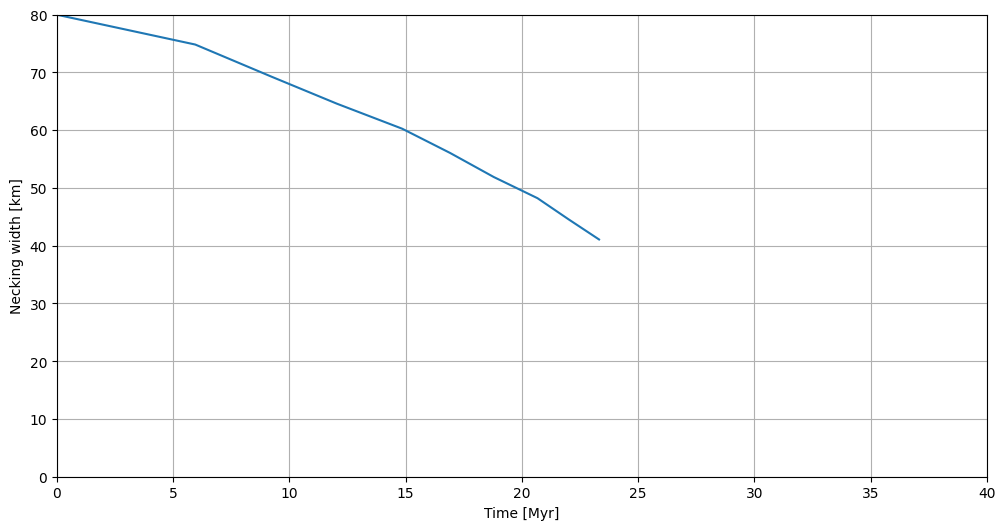

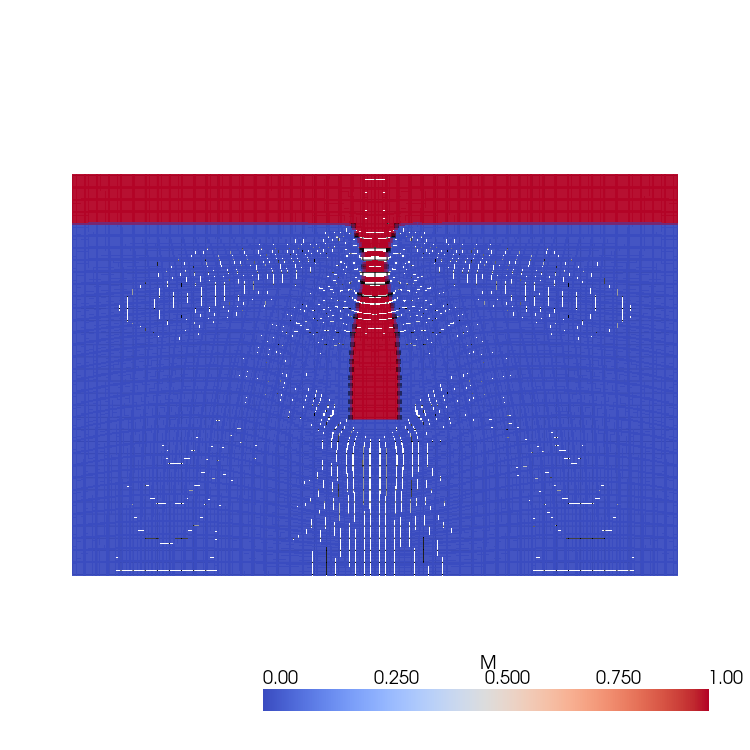

In [5]:
while step < nsteps:
    
    ### Get the x coordinates of the passive tracers
    with passiveSwarm_L.access():
        PS_L =  uw.utilities.gather_data(passiveSwarm_L.data[:,0], bcast=True)
    
    with passiveSwarm_R.access():
        PS_R =  uw.utilities.gather_data(passiveSwarm_R.data[:,0], bcast=True)
        
    L_xmax = PS_L.max()
    R_xmin = PS_R.min()
    
    #### calculate the minimum necking width   
    NeckWidth[step]    = R_xmin - L_xmax
    time_array[step]   = time
        
    ### save loop
    if step % 5 == 0 and step != restart_step:
        if uw.mpi.rank==0:
            print(f'\n\nSave data: \n\n')
        ### update fields first
        updateFields(time = time)
        ### save mesh variables
        saveData(step=step, outputPath=outputPath, time = time)

        ### remove nan values, if any. Convert to km and Myr
        NeckWidth_d = dim(NeckWidth[~np.isnan(NeckWidth)], u.kilometer)
        time_array_d   = dim(time_array[~np.isnan(time_array)], u.megayear)
        if uw.mpi.rank == 0:
            np.savez_compressed(f'{outputPath}/NeckWidth-{res}km', NeckWidth_d.m)
            np.savez_compressed(f'{outputPath}/modelTime-{res}km', time_array_d.m)
        
    ### print some stuff    
    if uw.mpi.rank==0:
        print(f"\n\nStep: {str(step).rjust(3)}, time: {dim(time, u.megayear).m:6.2f} Myr, Necking width:  {dim(NeckWidth[step], u.kilometer).m:6.2f} km \n\n")
        
    
    ### solve stokes 
    stokes.solve(zero_init_guess=False)
    ### estimate dt
    dt = 0.5 * stokes.estimate_dt()


    ### advect the swarm
    swarm.advection(stokes.u.sym, dt, corrector=False, evalf=True)
    
    passiveSwarm_L.advection(stokes.u.sym, dt, corrector=False, evalf=True)
    
    passiveSwarm_R.advection(stokes.u.sym, dt, corrector=False, evalf=True)
    
        
    step+=1
    time+=dt

# %% [markdown]
# #### Check the results against the benchmark 

# %%
### remove nan values, if any. Convert to km and Myr
NeckWidth_d = dim(NeckWidth[~np.isnan(NeckWidth)], u.kilometer)
time_array_d   = dim(time_array[~np.isnan(time_array)], u.megayear)
if uw.mpi.rank == 0:
    np.savez_compressed(f'{outputPath}NeckWidth-{res}km', NeckWidth_d.m)
    np.savez_compressed(f'{outputPath}modelTime-{res}km', time_array_d.m)

# %%
### remove nan values, if any. Convert to km and Myr
NeckWidth_d = dim(NeckWidth[~np.isnan(NeckWidth)], u.kilometer)
time_array_d   = dim(time_array[~np.isnan(time_array)], u.megayear)
if uw.mpi.rank == 0:
    np.savez_compressed(f'{outputPath}NeckWidth-{res}km', NeckWidth_d.m)
    np.savez_compressed(f'{outputPath}modelTime-{res}km', time_array_d.m)


if uw.mpi.rank==0:
    print('Initial: t = {0:.3f}, w = {1:.3f}'.format(time_array_d[0], NeckWidth_d[0]))
    print('Final:   t = {0:.3f}, w = {1:.3f}'.format(time_array_d[-1], NeckWidth_d[-1]))

    
if uw.mpi.rank==0:
        
    import matplotlib.pyplot as plt

    fig = plt.figure()
    fig.set_size_inches(12, 6)
    ax = fig.add_subplot(1,1,1)
    ax.plot(time_array_d.m, NeckWidth_d.m) 
    ax.set_xlabel('Time [Myr]')
    ax.set_ylabel('Necking width [km]')

    plt.ylim(0, 80)
    plt.xlim(0, 40)
    plt.grid()

    plt.savefig(f'{outputPath}slabDetachment_res={res}km_NeckWidth.pdf', dpi=500)

    plt.show()

# %%
if uw.mpi.size==1 and render == True:
    plot_mat()